In [1]:
!pip -q install torch torchvision torchgeo


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchgeo.datasets as datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 652.1/652.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
ds = datasets.EuroSAT(
    root="./data",
    split="train",
    bands=["B04", "B03", "B02"],   # RGB bands [1](https://torchgeo.readthedocs.io/en/stable/_modules/torchgeo/datasets/eurosat.html)
    download=True
)

print("Example image shape:", ds[0]["image"].shape)  # should be [3,64,64]
print("Example label:", int(ds[0]["label"]))         # labels are in [0..9] [1](https://torchgeo.readthedocs.io/en/stable/_modules/torchgeo/datasets/eurosat.html)

100%|██████████| 314k/314k [00:00<00:00, 44.2MB/s]
100%|██████████| 2.07G/2.07G [00:21<00:00, 95.0MB/s]


Example image shape: torch.Size([3, 64, 64])
Example label: 0


In [3]:
keep_map = {1: 0, 7: 1, 8: 2}  # remap -> 0..2 [2](https://huggingface.co/datasets/blanchon/EuroSAT_RGB/blob/main/README.md)

class Simple3Class(Dataset):
    def __init__(self, base):
        self.base = base
        self.ids = []
        for i in range(len(base)):
            y = int(base[i]["label"])
            if y in keep_map:
                self.ids.append(i)

        # Simple ResNet-ready transforms
        self.tf = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Normalize([0.485, 0.456, 0.406],   # ImageNet mean (RGB)
                                 [0.229, 0.224, 0.225])   # ImageNet std  (RGB)
        ])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sample = self.base[self.ids[idx]]
        x = sample["image"].float()    # [3,H,W]
        y = keep_map[int(sample["label"])]

        # If values are large (Sentinel-like), scale down a bit (keeps training stable)
        if x.max() > 1:
            x = x / 10000.0

        x = self.tf(x)
        return x, torch.tensor(y, dtype=torch.long)

ds3 = Simple3Class(ds)
train_loader = DataLoader(ds3, batch_size=32, shuffle=True)

print("3-class samples:", len(ds3))

3-class samples: 5110


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

for p in model.parameters():
    p.requires_grad = False  # freeze backbone

model.fc = nn.Linear(model.fc.in_features, 3)  # 3 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


In [6]:
for epoch in range(15):
    model.train()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} done | loss = {loss.item():.4f}")

print("Done!")

Epoch 1 done | loss = 0.0156
Epoch 2 done | loss = 0.1071
Epoch 3 done | loss = 0.0106
Epoch 4 done | loss = 0.0230
Epoch 5 done | loss = 0.0235
Epoch 6 done | loss = 0.0044
Epoch 7 done | loss = 0.0191
Epoch 8 done | loss = 0.1248
Epoch 9 done | loss = 0.0271
Epoch 10 done | loss = 0.0375
Epoch 11 done | loss = 0.0148
Epoch 12 done | loss = 0.0265
Epoch 13 done | loss = 0.0459
Epoch 14 done | loss = 0.0036
Epoch 15 done | loss = 0.0046
Done!


In [7]:
# --- Load EuroSAT TEST split (RGB bands) ---
ds_test = datasets.EuroSAT(
    root="./data",
    split="test",
    bands=["B04", "B03", "B02"],   # RGB bands [1](https://torchgeo.readthedocs.io/en/stable/_modules/torchgeo/datasets/eurosat.html)
    download=True
)

# Reuse the same Simple3Class wrapper and keep_map
ds3_test = Simple3Class(ds_test)

test_loader = DataLoader(ds3_test, batch_size=32, shuffle=False)
print("Test samples (3-class):", len(ds3_test))

100%|██████████| 104k/104k [00:00<00:00, 53.4MB/s]


Test samples (3-class): 1691


In [8]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Test Accuracy:", correct / total)

Test Accuracy: 0.9952690715552928


In [10]:
import torch

model.eval()
cm = torch.zeros(3, 3, dtype=torch.int64)

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images).argmax(1)

        for t, p in zip(labels, preds):
            cm[t.long(), p.long()] += 1

print("Confusion Matrix:\n", cm)

# Optional: print per-class accuracy
classes = ["Forest", "Residential", "River"]  # mapped from labels 1,7,8 [2](https://huggingface.co/datasets/blanchon/EuroSAT_RGB/blob/main/README.md)
for i in range(3):
    acc = cm[i, i].item() / max(cm[i].sum().item(), 1)
    print(f"{classes[i]} accuracy: {acc:.3f}")

Confusion Matrix:
 tensor([[608,   0,   0],
        [  1, 552,   1],
        [  5,   1, 523]])
Forest accuracy: 1.000
Residential accuracy: 0.996
River accuracy: 0.989


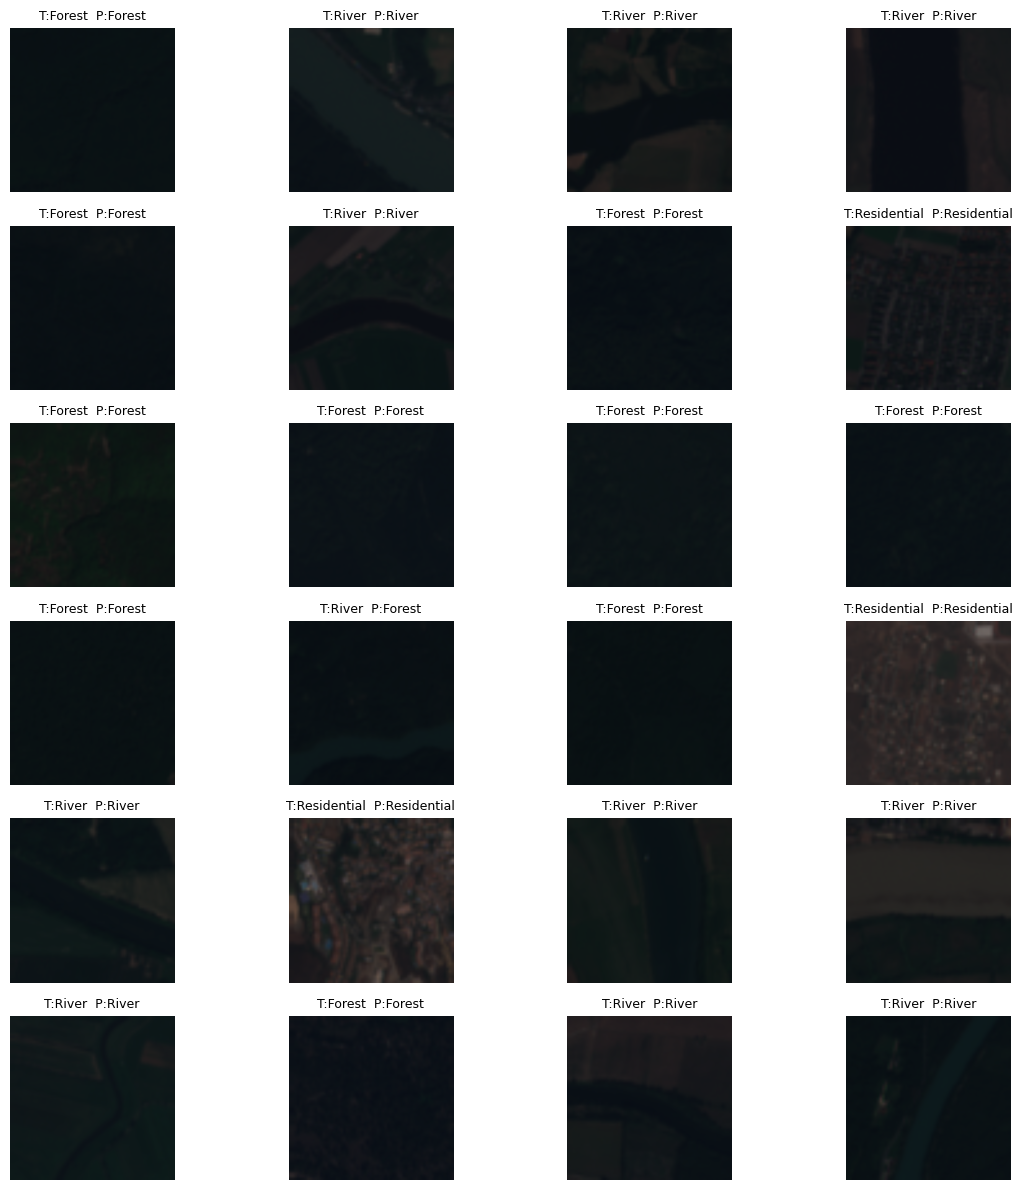

In [19]:
import random
import torch
import matplotlib.pyplot as plt

classes = ["Forest", "Residential", "River"]

model.eval()

N = 24  # number of random samples to show
rows, cols = 6, 4

# pick random indices from the dataset (not just one batch)
idxs = random.sample(range(len(ds3_test)), N)

plt.figure(figsize=(12, 12))

mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

with torch.no_grad():
    for i, idx in enumerate(idxs):
        x, y = ds3_test[idx]                 # x is already transformed/normalized
        pred = model(x.unsqueeze(0).to(device)).argmax(1).item()

        img = (x.cpu() * std + mean).clamp(0, 1)

        plt.subplot(rows, cols, i+1)
        plt.imshow(img.permute(1,2,0))
        plt.title(f"T:{classes[int(y)]}  P:{classes[pred]}", fontsize=9)
        plt.axis("off")

plt.tight_layout()
plt.show()

In [13]:
import torch

classes = ["Forest", "Residential", "River"]  # 0,1,2

model.eval()
pred_counts = {0: 0, 1: 0, 2: 0}
true_counts = {0: 0, 1: 0, 2: 0}

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images).argmax(1)

        for t in labels.tolist():
            true_counts[int(t)] += 1
        for p in preds.tolist():
            pred_counts[int(p)] += 1

print("TRUE counts :", {classes[k]: v for k, v in true_counts.items()})
print("PRED counts :", {classes[k]: v for k, v in pred_counts.items()})

TRUE counts : {'Forest': 608, 'Residential': 554, 'River': 529}
PRED counts : {'Forest': 614, 'Residential': 553, 'River': 524}
